In [2]:
# 월드컵분석에 쓰인 라이브러리
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import plotly.graph_objects as go

In [3]:
matches = pd.read_csv('C:/Users/dlagh/Desktop/worldcup-prediction/data/results.csv')
matches = matches[matches['tournament'] != 'Friendly']


In [4]:
rank = pd.read_csv('C:/Users/dlagh/Desktop/worldcup-prediction/data/fifa_ranking.csv')
rank.head(2)

,id,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,43818,82,Iraq,IRQ,15,0,0,AFC,1992-12-31
1,43873,107,Mozambique,MOZ,9,0,0,CAF,1992-12-31


In [5]:
import datetime
matches['date'] = pd.to_datetime(matches['date'])
rank['rank_date'] = pd.to_datetime(rank['rank_date'])
rank['year'] = rank['rank_date'].dt.year
matches['year'] = matches['date'].dt.year

rankings_sub = rank[rank['rank_date'] > '2011-08-24']
matches_sub = matches[matches['date'] > '2011-08-24']

In [6]:
rankings_sub.head()
matches_sub.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year
33488,2011-08-27,Fiji,Tahiti,3,0,Pacific Games,Boulari,New Caledonia,True,2011
33490,2011-08-27,New Caledonia,Vanuatu,5,0,Pacific Games,Nouméa,New Caledonia,False,2011
33492,2011-08-27,Papua New Guinea,Cook Islands,4,0,Pacific Games,Boulari,New Caledonia,True,2011
33493,2011-08-27,Solomon Islands,Guam,7,0,Pacific Games,Nouméa,New Caledonia,True,2011
33494,2011-08-27,Tuvalu,American Samoa,4,0,Pacific Games,Nouméa,New Caledonia,True,2011


In [7]:
rankings_sub.head()

,id,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date,year
40621,43858,67,Gabon,GAB,489,482,0,CAF,2011-09-21,2011
40622,43881,68,Sierra Leone,SLE,488,348,24,CAF,2011-09-21,2011
40623,43927,69,Ecuador,ECU,481,491,3,CONMEBOL,2011-09-21,2011
40624,43957,75,Lithuania,LTU,459,552,19,UEFA,2011-09-21,2011
40625,43932,71,Albania,ALB,474,546,14,UEFA,2011-09-21,2011


In [8]:
rankings_sub = rankings_sub[['rank', 'country_full', 'total_points', 'year']]
rankings_sub = rankings_sub.groupby(['year', 'country_full'], as_index=False).agg({'rank': 'mean', 'total_points': 'mean'})

In [9]:
matches_all = matches_sub.merge(rankings_sub, left_on=['home_team', 'year'], right_on=['country_full', 'year'], how='inner')
matches_all = matches_all.merge(rankings_sub, left_on=['away_team', 'year'], right_on=['country_full', 'year'], how='inner')
matches_all.drop(['date', 'tournament', 'city', 'country', 'year', 'country_full_x', 'country_full_y'], axis=1, inplace=True)
matches_all.head()

,home_team,away_team,home_score,away_score,neutral,rank_x,total_points_x,rank_y,total_points_y
0,Fiji,Tahiti,3,0,True,153.75,145.50,183.0,71.75
1,New Caledonia,Tahiti,3,1,False,160.00,122.00,183.0,71.75
2,New Caledonia,Vanuatu,5,0,False,160.00,122.00,173.0,92.00
3,American Samoa,Vanuatu,0,8,True,199.00,15.25,173.0,92.00
4,Guam,Vanuatu,1,4,True,188.50,36.00,173.0,92.00


In [10]:
matches_all['total_points_diff'] = matches_all['total_points_x'] - matches_all['total_points_y']
matches_all['rank_diff'] = matches_all['rank_x'] - matches_all['rank_y']
matches_all['neutral'] = matches_all['neutral'].astype(int)
matches_all['is_win'] = (matches_all['home_score'] - matches_all['away_score']).apply(lambda x: 1 if x>0 else 0)
train = matches_all.drop(['home_team', 'away_team', 'home_score', 'away_score'], axis=1)
train.head()
# goal differece와 시차

,neutral,rank_x,total_points_x,rank_y,total_points_y,total_points_diff,rank_diff,is_win
0,1,153.75,145.50,183.0,71.75,73.75,-29.25,1
1,0,160.00,122.00,183.0,71.75,50.25,-23.00,1
2,0,160.00,122.00,173.0,92.00,30.00,-13.00,1
3,1,199.00,15.25,173.0,92.00,-76.75,26.00,0
4,1,188.50,36.00,173.0,92.00,-56.00,15.50,0


In [11]:
train_X = train.drop('is_win', axis=1)
train_y = train['is_win']

In [12]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [13]:
classifiers = {'Random Forest': RandomForestClassifier(n_estimators=300),
              'LightGBM': LGBMClassifier(n_estimators=300, learning_rate=.01),
              'Logistic Regression': LogisticRegression(C=1e-5)}

Running Random Forest
Running LightGBM
Running Logistic Regression


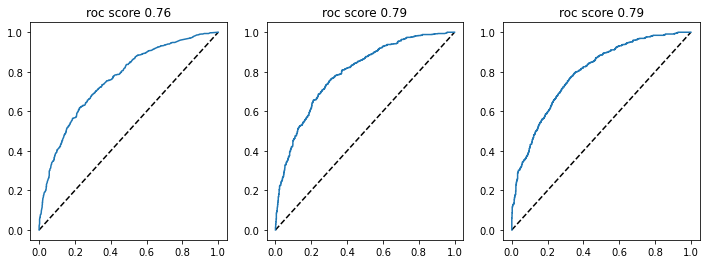

In [14]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3)

fig = plt.figure(figsize=[12, 4])
for i, (name, clf) in enumerate(classifiers.items()):
    print('Running', name)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    # plot
    ax = fig.add_subplot(1, 3, i+1)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fpr, tpr)
    ax.set_title('roc score {0:.2f}'.format(roc_auc_score(y_test, y_pred)))

<AxesSubplot:title={'center':'y_pred'}, xlabel='[y_true]'>

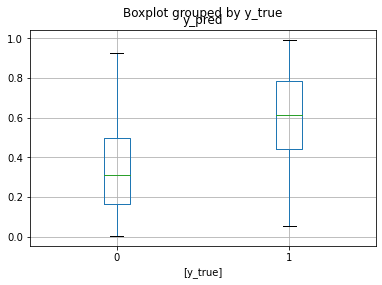

In [15]:
pd.DataFrame({'y_pred': y_pred, 'y_true': y_test}).boxplot(by='y_true')

In [16]:
rf = RandomForestClassifier(n_estimators=300)
rf = rf.fit(train_X, train_y)

lr = LogisticRegression(C=1e-5)
lr = lr.fit(train_X, train_y)

lgb = LGBMClassifier(n_estimators=300, learning_rate=.01)
lgb = lgb.fit(train_X, train_y)

In [17]:
a=pd.DataFrame([['Portugal','H',1660.25, 8,2022],['Uruguay','H',1641.05, 16,2022],['Korea Republic','H',1522.85, 29,2022],['Ghana','H',1381.45,61,2022]],columns=['Team','Group','total_points','rank','year'])
world_cup_rankings= a.set_index('Team')
world_cup_rankings

,Group,total_points,rank,year
Team,,,,
Portugal,H,1660.25,8,2022
Uruguay,H,1641.05,16,2022
Korea Republic,H,1522.85,29,2022
Ghana,H,1381.45,61,2022


In [23]:
world_cup_rankings['Points'] = 0
for group in world_cup_rankings['Group'].unique():
    print('*******************************')
    print('Simulating Group', group)
    group_teams = list(world_cup_rankings.query('Group=="{}"'.format(group)).index)
    for home, away in combinations(group_teams, 2):
        print('----------------------------------')
        print('{} vs {}'.format(home, away))
        row = pd.DataFrame(columns=train_X.columns)
        row.loc[0, 'neutral'] = 1
        row['total_points_x'] = world_cup_rankings.loc[home, 'total_points']
        row['rank_x'] = world_cup_rankings.loc[home, 'rank']
        row['total_points_y'] = world_cup_rankings.loc[away, 'total_points']
        row['rank_y'] = world_cup_rankings.loc[away, 'rank']
        row['total_points_diff'] = row['total_points_x'] - row['total_points_y']
        row['rank_diff'] = row['rank_x'] - row['rank_y']
        # get wining probability
        y_pred = np.mean([lr.predict_proba(row)[:, 1][0], lgb.predict_proba(row.values)[:, 1][0], rf.predict_proba(row)[:, 1][0]])
        # if y_pred in [0.4, 0.55] then draw
        if (y_pred > 0.4) & (y_pred < 0.55):
            print('Draw',y_pred)
            world_cup_rankings.loc[home, 'Points'] += 1
            world_cup_rankings.loc[away, 'Points'] += 1
        else:
            # give a sense of randomness
            is_win = np.random.choice([1, 0], p=[y_pred, 1-y_pred])
            if is_win:
                print('{} wins({})'.format(home,y_pred))
                world_cup_rankings.loc[home, 'Points'] += 3
            else:
                world_cup_rankings.loc[away, 'Points'] += 3
                print('{} wins({})'.format(away,1-y_pred))

*******************************
Simulating Group H
----------------------------------
Portugal vs Uruguay
Uruguay wins(0.6245146119125224)
----------------------------------
Portugal vs Korea Republic
Draw 0.4749296655559705
----------------------------------
Portugal vs Ghana
Portugal wins(0.8105645329684061)
----------------------------------
Uruguay vs Korea Republic
Draw 0.44960395589349034
----------------------------------
Uruguay vs Ghana
Uruguay wins(0.7681629444773771)
----------------------------------
Korea Republic vs Ghana
Draw 0.5122277477828537


In [29]:
world_cup_rankings.sort_values('Points',ascending=False)

,Group,total_points,rank,year,Points
Team,,,,,
Uruguay,H,1641.05,16,2022,7
Portugal,H,1660.25,8,2022,4
Korea Republic,H,1522.85,29,2022,3
Ghana,H,1381.45,61,2022,1
